## Basic Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

## Initializing Constants

In [2]:
NUM_TRIALS = 20000
EPS = 0.1
BANDIT_REWARDS = [1,2,3,4]

## Bandit Class

In [3]:
from abc import ABC, abstractmethod
from logs import *

logging.basicConfig
logger = logging.getLogger("MAB Application")


# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

ch.setFormatter(CustomFormatter())

logger.addHandler(ch)

In [4]:
class Bandit(ABC):
    ##==== DO NOT REMOVE ANYTHING FROM THIS CLASS ====##

    @abstractmethod
    def __init__(self, p):
        pass

    @abstractmethod
    def __repr__(self):
        pass

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    def report(self):
        # store data in csv
        # print average reward (use f strings to make it informative)
        # print average regret (use f strings to make it informative)
        
        #Done it outside report function
        
        pass

## Visualization Class

In [5]:
class Visualization():
    """
    A class for visualizing bandit simulations and data.

    Attributes:
        None

    Methods:
        plot1(bandits, trial, use_log_scale=False):
            Plot bandit probability density functions after a specified number of trials.

        plot2(data, title_name, label_name, color_name, use_log_scale=False):
            Create a line plot of data with specified title, label, and color.

    """

    @staticmethod
    def plot1(bandits, trial, use_log_scale=False):
        """
        Plot bandit probability density functions after a specified number of trials.

        Parameters:
            bandits (list): List of bandit objects to visualize.
            trial (int): The number of trials or experiments.
            use_log_scale (bool): Use a logarithmic scale for the x-axis if True.

        Returns:
            None

        """
        x = np.linspace(-3, 6, 200)
        for b in bandits:
            y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
            #y = norm.pdf(x, b.sample(), np.sqrt(1. / b.lambda_))
            plt.plot(x, y, label=f"real mean: {b.true_mean:.4f}, num plays: {b.N}")

        plt.title("Bandit distributions after {} trials".format(trial))
        plt.legend()
        
        if use_log_scale:
            plt.xscale('log')  # Use a logarithmic scale for the y-axis
            
        plt.show()
        
    @staticmethod
    def plot2(data, title_name, label_name, color_name, use_log_scale = False):
        """
        Create a line plot of data with specified title, label, and color.

        Parameters:
            data (list or array-like): Data to be plotted.
            title_name (str): Title for the plot.
            label_name (str): Label for the data series.
            color_name (str): Color of the plot line.
            use_log_scale (bool): Use a logarithmic scale for the x-axis if True.

        Returns:
            None

        """
        plt.plot(data, label = label_name, color = color_name)
        plt.title(title_name)
        plt.xlabel("Num")
        plt.ylabel(label_name)
        plt.legend()
        
        if use_log_scale:
            plt.xscale('log')  # Use a logarithmic scale for the y-axis    
            
        plt.show()
        

## Epsilon-Greedy class

In [6]:
class EpsilonGreedy(Bandit):
    """
    Epsilon-Greedy bandit algorithm for multi-armed bandit problems.

    Parameters:
    p (float): The true win rate for the bandit.

    Attributes:
    p (float): The true win rate for the bandit.
    p_estimate (float): Estimated win rate of the bandit.
    N (int): Number of times the bandit has been pulled.

    Methods:
    pull(): Simulate a pull from the bandit.
    update(x): Update the estimated win rate based on a new observation.
    experiment(bandit_probs, t, N=NUM_TRIALS): Run the Epsilon-Greedy experiment.
    report(bandit_probs, N=NUM_TRIALS): Generate a report of the experiment results.
    """
    
    def __init__(self, p):
        """
        Initialize a bandit with a given true win rate.

        Parameters:
        p (float): The true win rate for the bandit.
        """
        self.p = p
        self.p_estimate = 0
        self.N = 0

    def __repr__(self):
        return 'A Bandit with {} Win Rate'.format(self.p)

    def pull(self):
        """
        Simulate a pull from the bandit and return the observed reward.

        Returns:
        float: The observed reward from pulling the bandit.
        """
        return np.random.randn() + self.p

    def update(self, x):
        """
        Update the estimated win rate of the bandit based on a new observation.

        Parameters:
        x (float): The observed reward from the bandit pull.
        """
        self.N += 1
        self.p_estimate = (1 - 1.0/self.N) * self.p_estimate + 1.0/self.N * x

    def experiment(self, bandit_probs, t, N=NUM_TRIALS):
        """
        Run the Epsilon-Greedy experiment with multiple bandits.

        Parameters:
        bandit_probs (list of float): True win rates for each bandit.
        t (int): Total number of pulls to be performed.
        N (int): Number of trials in the experiment (default: NUM_TRIALS).

        Returns:
        tuple: A tuple containing data, bandit selections, and bandits' information.
        """
        bandits = [EpsilonGreedy(p) for p in bandit_probs]
        Bandit_Sel = []  # bandit selection
        means = np.array(bandit_probs)
        true_best = np.argmax(means)
        count_suboptimal = 0
        sample_points = [10, 50, 100, 500, 1000, 1500, 1999]
        data = np.empty(N)
        eps = 1/t

        for i in range(N):
            p = np.random.random() 
            
            if p < eps: 
                j = np.random.choice(len(bandits)) 
            else:
                j = np.argmax([b.p_estimate for b in bandits])
            
            x = bandits[j].pull() 
            bandits[j].update(x)
            
            if j != true_best: 
                count_suboptimal += 1
            Bandit_Sel.append(j)
       
            data[i] = x 
            t+=1 
            eps = 1/t

        global Reward
        Reward = data
        global Bandits_Sel
        Bandits_Sel = Bandit_Sel

        cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

        df = pd.DataFrame()
        df["Bandit"] = [b for b in bandits]
        df["Reward"] = [b.p_estimate for b in bandits]
        df["Algorithm"] = "EpsilonGreedy"

        global Greedy
        Greedy = df

        for b in bandits:
            print("Estimated average reward where epsilon for {0} = {1} : {2},\n number of times pulled {3}".format(b, eps, b.p_estimate, b.N))
        print("\n")
        print("Percent suboptimal where epsilon = {0} : {1}".format(eps, float(count_suboptimal) / N))
        print("\n")
        print(f'Cummulative average: {cumulative_average}')
        return data, Bandit_Sel, bandits

    def report(self, bandit_probs, N=NUM_TRIALS):
        """
        Generate a report of the Epsilon-Greedy experiment results.

        Parameters:
        bandit_probs (list of float): True win rates for each bandit.
        N (int): Number of trials in the experiment (default: NUM_TRIALS).

        Returns:
        ndarray: An array representing the regret over time.
        """
        bandits = [EpsilonGreedy(p) for p in bandit_probs]
        sum_ = []
        means = np.array(bandit_probs)
        for i in Bandits_Sel:
            sum_.append(bandits[i].p)

        cumulative_reward = np.cumsum(Reward)
        regret = np.empty(N)
        
        for i in range(len(Reward)):
            regret[i] = N*max(means) - cumulative_reward[i]
            
        return regret


## Thompson Sampling class

In [7]:
class ThompsonSampling(Bandit):
    """
    Thompson Sampling bandit algorithm for multi-armed bandit problems.

    Parameters:
    true_mean (float): The true mean reward of the bandit.
    plot_during_experiment (bool): Whether to plot results during the experiment (default: True).

    Attributes:
    true_mean (float): The true mean reward of the bandit.
    m (float): Current estimate of the mean reward.
    lambda_ (float): Precision parameter for estimating mean.
    tau (float): Precision parameter for estimating true mean.
    N (int): Number of times the bandit has been pulled.
    plot_during_experiment (bool): Whether to plot results during the experiment.

    Methods:
    pull(): Simulate a pull from the bandit and return the observed reward.
    sample(): Sample from the posterior distribution of the bandit's mean.
    update(x): Update the estimate of the bandit's mean and precision parameters.
    experiment(bandit_rewards, NUM_TRIALS): Run the Thompson Sampling experiment.
    plot1(bandits, trial): Plot the results of the experiment at a specific trial.
    report(bandit_rewards, N=NUM_TRIALS): Generate a report of the experiment results.
    """
    def __init__(self, true_mean, plot_during_experiment=True):
        """
        Initialize a bandit with a true mean reward and optional plotting setting.

        Parameters:
        true_mean (float): The true mean reward of the bandit.
        plot_during_experiment (bool): Whether to plot results during the experiment (default: True).
        """
        self.true_mean = true_mean
        self.m = 0
        self.lambda_ = 1
        self.tau = 1
        self.N = 0
        self.plot_during_experiment = plot_during_experiment
        
    def __repr__(self):
        return 'A Bandit with {} Win Rate'.format(self.true_mean)

    def pull(self):
        """
        Simulate a pull from the bandit and return the observed reward.

        Returns:
        float: The observed reward from pulling the bandit.
        """
        return np.random.randn() / np.sqrt(self.tau) + self.true_mean

    def sample(self):
        """
        Sample from the posterior distribution of the bandit's mean.

        Returns:
        float: Sampled mean from the posterior distribution.
        """
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        """
        Update the estimate of the bandit's mean and precision parameters.

        Parameters:
        x (float): The observed reward from the bandit pull.
        """
        self.m = (self.tau * x + self.lambda_ * self.m) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
        
    def experiment(self, bandit_rewards, NUM_TRIALS):
        """
        Run the Thompson Sampling experiment with multiple bandits.

        Parameters:
        bandit_rewards (list of float): True mean rewards for each bandit.
        NUM_TRIALS (int): Total number of trials in the experiment.

        Returns:
        ndarray: An array representing the cumulative average rewards over time.
        """
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        bandits_selected =[]
        sample_points = [5,20,50,100,200,500,1000,1999,5000,10000,19999]
        rewards = np.empty(NUM_TRIALS)
        
        
        global Reward_s
        Reward_s = rewards
        global Bands_sel
        Bands_sel = bandits_selected

        for i in range(NUM_TRIALS):
            j = np.argmax([b.sample() for b in bandits]) 

            if i in sample_points and self.plot_during_experiment:
                 self.plot1(bandits, i)

            x = bandits[j].pull()

            bandits[j].update(x)

            rewards[i] = x
            
            bandits_selected.append(j)

        cumulative_average = np.cumsum(rewards) / (np.arange(NUM_TRIALS) + 1)
        
        df = pd.DataFrame()
        for b in bandits:
            print("Estimated average reward {0}  {1},\n number of times pulled {2}".format(b,b.m, b.N))
    
        print("\n")
    
        print(f'Cummulative average: {cumulative_average}')
        
        df = pd.DataFrame()
        df["Bandit"] = [b for b in bandits]
        df["Reward"] = [b.m for b in bandits]
        df["Algorithm"] = "ThompsonSampling"
        
        global Thompson
        Thompson = df
        
        return cumulative_average
    
    def plot1(self, bandits, trial):
        """
        Plot the results of the experiment at a specific trial.

        Parameters:
        bandits (list): List of bandits in the experiment.
        trial (int): The trial number for which to plot results.
        """
        Visualization.plot1(bandits, trial)
    
    def report(self, bandit_rewards, N = NUM_TRIALS):
        """
        Generate a report of the Thompson Sampling experiment results.

        Parameters:
        bandit_rewards (list of float): True mean rewards for each bandit.
        N (int): Number of trials in the experiment (default: NUM_TRIALS).

        Returns:
        ndarray: An array representing the regret over time.
        """
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        sum_= []
        for i in Bands_sel:
            sum_.append(bandits[i].true_mean)
        
        
        true_best = max(bandit_rewards)
        best_reward = np.arange(N)
        
        cumulative_reward = np.cumsum(Reward_s)
        regret = np.empty(N)
        
        for i in range(len(Reward_s)):
            regret[i] = N*max([b.true_mean for b in bandits]) - cumulative_reward[i]
       
        
        return regret 
         

## Thompson Sampling Graphs

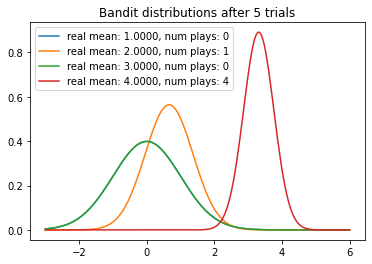

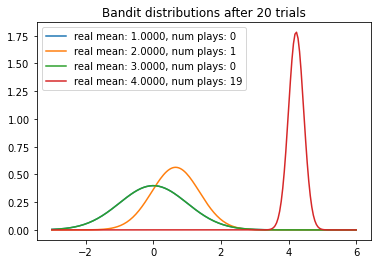

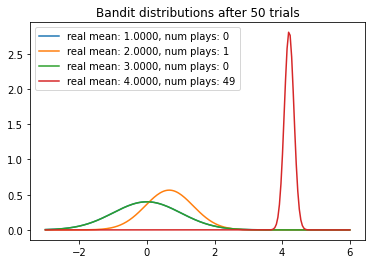

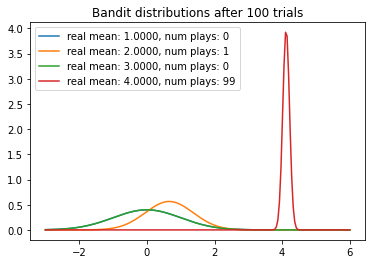

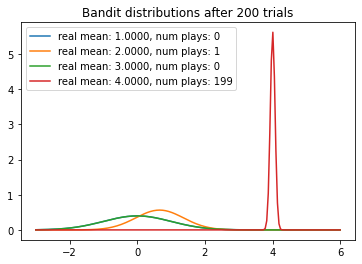

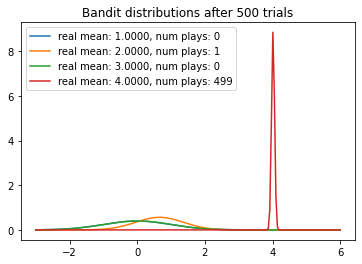

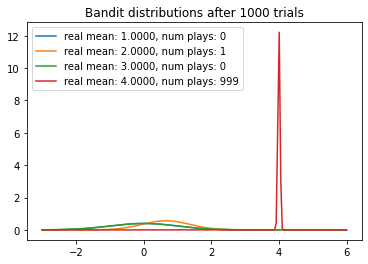

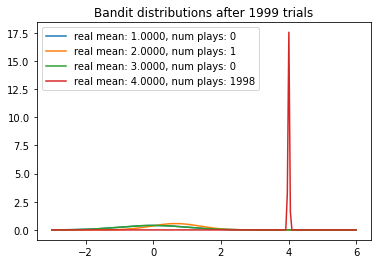

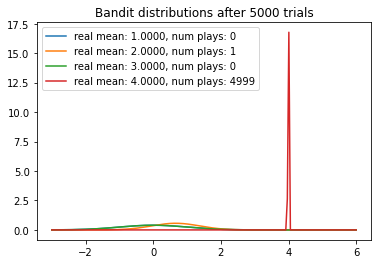

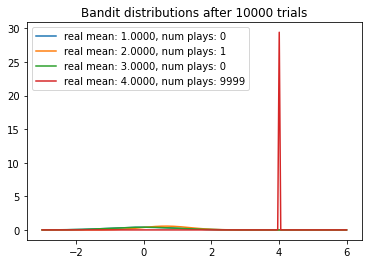

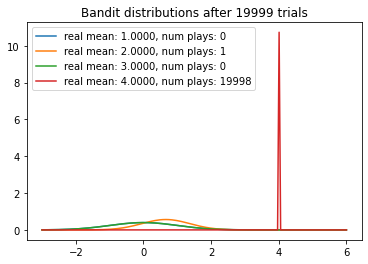

Estimated average reward A Bandit with 1 Win Rate  0,
 number of times pulled 0
Estimated average reward A Bandit with 2 Win Rate  0.6608180681718732,
 number of times pulled 1
Estimated average reward A Bandit with 3 Win Rate  0,
 number of times pulled 0
Estimated average reward A Bandit with 4 Win Rate  3.997180288570777,
 number of times pulled 19999


Cummulative average: [1.32163614 2.49148753 3.35500147 ... 3.99729227 3.99723318 3.99724637]


array([1.32163614, 2.49148753, 3.35500147, ..., 3.99729227, 3.99723318,
       3.99724637])

In [8]:
ThompsonSampling(Bandit).experiment(BANDIT_REWARDS, NUM_TRIALS)

Estimated average reward A Bandit with 1 Win Rate  0.6580929818221365,
 number of times pulled 1
Estimated average reward A Bandit with 2 Win Rate  1.4302157306093468,
 number of times pulled 2
Estimated average reward A Bandit with 3 Win Rate  2.9764325788408454,
 number of times pulled 153
Estimated average reward A Bandit with 4 Win Rate  4.00551269528092,
 number of times pulled 19844


Cummulative average: [1.96814183 2.58365795 2.79929192 ... 3.99762667 3.99762749 3.99766884]


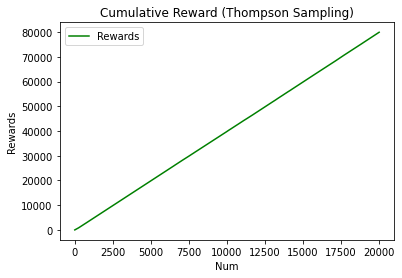

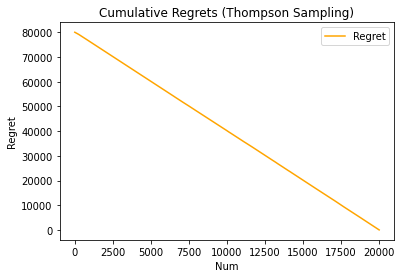

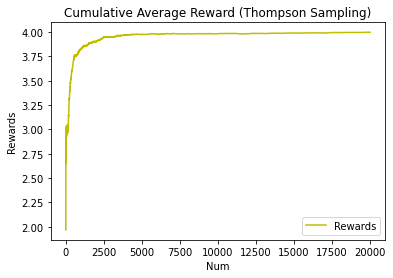

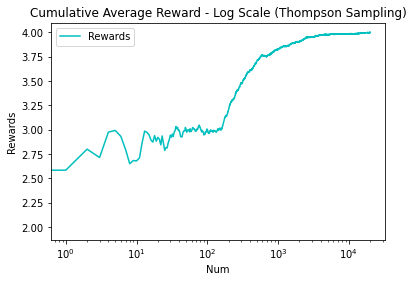

In [9]:
thompson_sampling = ThompsonSampling(BANDIT_REWARDS, plot_during_experiment=False)
cumulative_average = thompson_sampling.experiment(BANDIT_REWARDS, NUM_TRIALS)
regret2 = thompson_sampling.report(BANDIT_REWARDS, NUM_TRIALS)

# Plotting the results one by one using the Visualization class
Visualization.plot2(np.cumsum(Reward_s), "Cumulative Reward (Thompson Sampling)", "Rewards", 'g')
Visualization.plot2(regret2, "Cumulative Regrets (Thompson Sampling)", "Regret", 'orange')
Visualization.plot2(cumulative_average, "Cumulative Average Reward (Thompson Sampling)", "Rewards", 'y')
Visualization.plot2(cumulative_average, "Cumulative Average Reward - Log Scale (Thompson Sampling)", "Rewards", 'c', use_log_scale=True)


## Epsilon Greedy Graphs

Estimated average reward where epsilon for A Bandit with 1 Win Rate = 2.5e-05 : -0.4221440137785184,
 number of times pulled 1
Estimated average reward where epsilon for A Bandit with 2 Win Rate = 2.5e-05 : 2.0273020954746737,
 number of times pulled 1283
Estimated average reward where epsilon for A Bandit with 3 Win Rate = 2.5e-05 : 2.997426173757278,
 number of times pulled 18716
Estimated average reward where epsilon for A Bandit with 4 Win Rate = 2.5e-05 : 0,
 number of times pulled 0


Percent suboptimal where epsilon = 2.5e-05 : 1.0


Cummulative average: [-0.42214401  0.50897363  0.72278586 ...  2.93492831  2.93495666
  2.93502174]


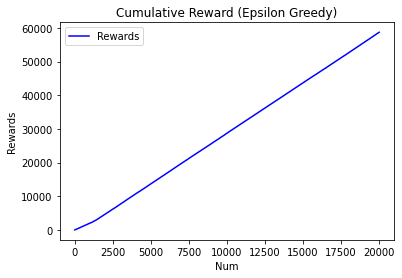

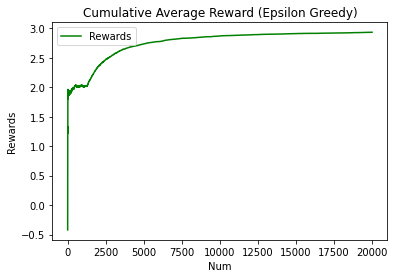

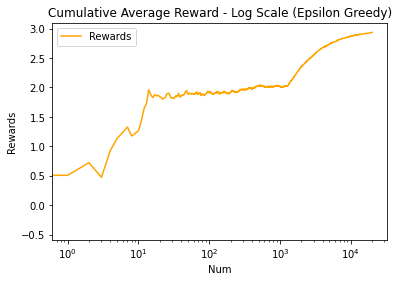

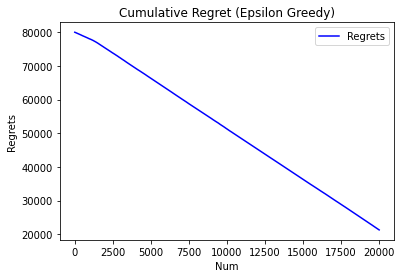

In [10]:
epsilon_greedy = EpsilonGreedy(EPS)
data, Bandits_Sel, bandits = epsilon_greedy.experiment(BANDIT_REWARDS, NUM_TRIALS)
regret1 = epsilon_greedy.report(BANDIT_REWARDS, NUM_TRIALS)

# Use the returned data to create plots
Visualization.plot2(np.cumsum(data), "Cumulative Reward (Epsilon Greedy)", "Rewards", 'b')
Visualization.plot2(np.cumsum(data) / (np.arange(NUM_TRIALS) + 1), "Cumulative Average Reward (Epsilon Greedy)", "Rewards", 'g')
Visualization.plot2(np.cumsum(data) / (np.arange(NUM_TRIALS) + 1), "Cumulative Average Reward - Log Scale (Epsilon Greedy)", "Rewards", 'orange', use_log_scale=True)
Visualization.plot2(regret1, "Cumulative Regret (Epsilon Greedy)", "Regrets", 'b')

## Storing the rewards in a CSV file ({Bandit, Reward, Algorithm})

In [11]:
EpsGreedy = pd.DataFrame({"Bandit" : Bandits_Sel, "Reward" : Reward, "Algorithm" : "Epsilon Greedy"})
EpsGreedy.to_csv('EpsilionGreedy.csv')
ThompsonSamp = pd.DataFrame({"Bandit" : Bands_sel, "Reward" : Reward_s, "Algorithm" : "Thompson Sampling"})
ThompsonSamp.to_csv('ThomsponSampling.csv')

In [12]:
Greedy.to_csv("Greedy.csv")
Thompson.to_csv("Thompson.csv")

## Comparing Graphs

In [13]:
def comparison(data1, label1, data2, label2, x_label, y_label, title, color1='g', color2='b', use_log_scale=False):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(data1, label=label1, color=color1)
    plt.plot(data2, label=label2, color=color2)
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    if use_log_scale:
        plt.xscale('log')  # Use a logarithmic scale for the y-axis
    plt.show()

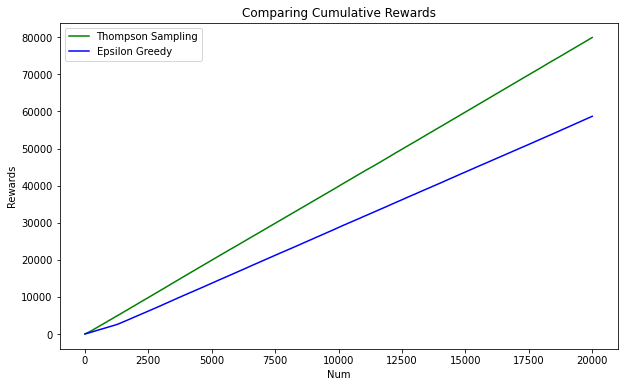

In [14]:
comparison(np.cumsum(Reward_s), "Thompson Sampling", np.cumsum(data), "Epsilon Greedy", 'Num', 'Rewards', 'Comparing Cumulative Rewards')

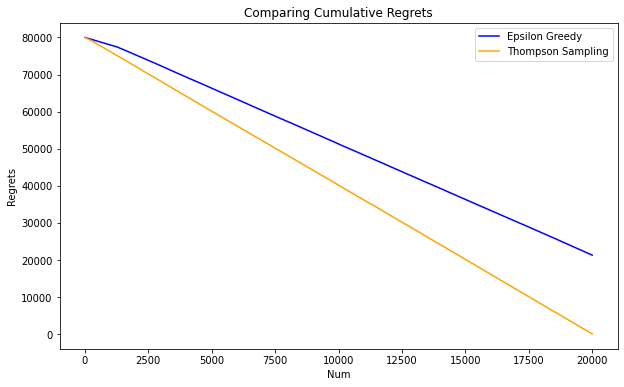

In [15]:
comparison(regret1, "Epsilon Greedy", regret2, "Thompson Sampling", 'Num', 'Regrets', 'Comparing Cumulative Regrets', color1='b', color2='orange')

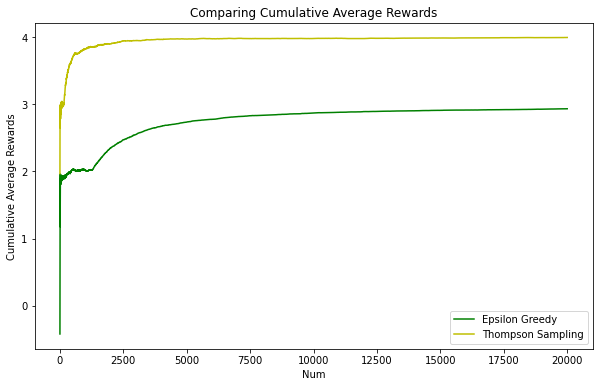

In [16]:
comparison(np.cumsum(data) / (np.arange(NUM_TRIALS) + 1), "Epsilon Greedy", cumulative_average, "Thompson Sampling", 'Num', 'Cumulative Average Rewards', 'Comparing Cumulative Average Rewards', color1='g', color2='y')

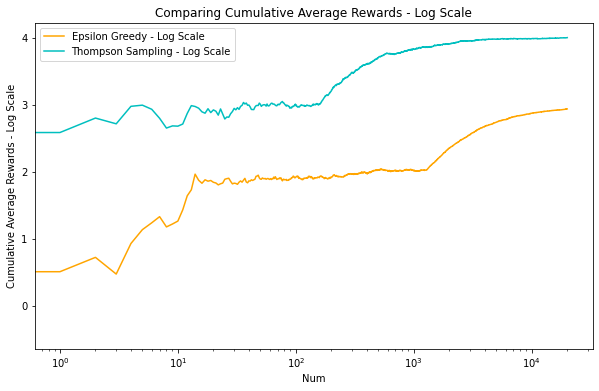

In [17]:
comparison(
    np.cumsum(data) / (np.arange(NUM_TRIALS) + 1),
    "Epsilon Greedy - Log Scale",
    cumulative_average,
    "Thompson Sampling - Log Scale",
    'Num',
    'Cumulative Average Rewards - Log Scale',
    'Comparing Cumulative Average Rewards - Log Scale',
    color1='orange',
    color2='c',
    use_log_scale=True
)
